# Transducing Language Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transduction import FST, FSA, EPSILON, PrecoverDecomp, examples, Precover
from transduction.util import display_table

import numpy as np
from arsenal.datastructures import LocatorMaxHeap
from dataclasses import dataclass

from tokenization.util import logsumexp, Chart

Notes

* I would favor moving to a general "prioritize however you see fit" design rather than hardcoding the LM prefix probability as the only design.

* For example, it may be possible to view trimming (or approximate trimming from co-accessibility in a coarse-grained precover) as a kind of priorization heuristic.
  
* I would prefer to defer rather than prune so that we have good methods for recovering from dead ends.

* I like to think of the enumeration algorithm as a prioritized materialization for the cross-production construction of the LM and the FST.  In the case of a neural language model, the LM's state space is the infinitely large and degenerate space of string prefixes.  We can contrast that with the case of a PFsA, where states come from a finite set.  How about PCFGs?  (The Bar-Hillel construction creates states of the form `(i,X,j)` where `i` and `j` are states of the automaton and `X` is a nonterminal in the PCFG.  It seems a little different that we triplets rather than pairs, but maybe there is an elegant way to reconcile this.) 

* It would be really nice if our enumeration method recovered exact algorithms when run on models with finitely many states (e.g., PCFG language models).

In [3]:
@dataclass(frozen=False, eq=True, unsafe_hash=True)
class Item:
    "Items used in search queue"
    weight: float
    state: object
    source: object
    def __repr__(self):
        return f'Item({self.weight:.3f}, {self.state}, {repr(self.source)})'

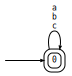

In [4]:
fst = examples.replace([('a', 'a'), ('b', 'b'), ('c', 'c')])
fst

In [5]:
from genparse import EarleyLM, EOS

In [6]:
lm = EarleyLM.from_string("""

.5: S -> a S
.4: S -> b S
.1: S -> c

""")
lm.logp_next = lambda x: Chart(float('-inf'), lm.p_next(x)).map_values(np.log)

In [7]:
def prioritized_enumeration(lm, fst, target, max_steps):
    
    precover = Precover(fst, target)
    fsa = precover.quotient
    Q = precover.quotient.stop
    R = precover.remainder.stop
    fsa.stop |= R
    fsa = fsa.trim()
    display(fsa)
    
    if not (set(target) <= fst.B):
        print(f'[warn] OOVs: {set(target) - self.fst.B}')

    remainder = []
    quotient = []
    queue = LocatorMaxHeap()
    
    for q in fsa.start:
        queue[Item(weight = 0, state = q, source = '')] = 0
    t = 0
    while queue:
        t += 1
        if t > max_steps:
            print(colors.light.red % 'stopped early')
            break
        (item, _) = queue.pop()
        #print('pop:', item)
        lm_logp_next = lm.logp_next(item.source)
        #display(lm_logp_next)
        if item.state in Q:
            quotient.append(item)
            continue
        if item.state in R:
            # add the eos probability here
            remainder.append(Item(
                weight = item.weight + lm_logp_next[EOS],
                state = item.state,
                source = item.source,
            ))
            remainder.append(item)
        for x, next_state in fsa.arcs(item.state):
            next_weight = float(item.weight + lm_logp_next[x])   # use LM state here
            if next_weight == -np.inf: continue
            next_item = Item(
                weight = next_weight,
                state = next_state,
                source = item.source + x,
            )
            #print('push:', next_item)
            queue[next_item] = next_weight
    
    #print()
    #print(f'{quotient = }')
    #print(f'{remainder = }')
    return (quotient, remainder)

In [8]:
prioritized_enumeration(lm, fst, 'abc', max_steps=50)

/home/timv/projects/tokenization/tokenization/util.py:323: RuntimeWarning: invalid value encountered in log
  return Chart(f(self.zero), [(k, f(v)) for k, v in self.items()])


([Item(-3.912, {((0, 0), 'abc')}, 'abc')], [])

In [9]:
prioritized_enumeration(lm, fst, 'aa', max_steps=100)

/home/timv/projects/tokenization/tokenization/util.py:323: RuntimeWarning: invalid value encountered in log
  return Chart(f(self.zero), [(k, f(v)) for k, v in self.items()])


([Item(-1.386, {((0, 0), 'aa')}, 'aa')], [])